<a href="https://colab.research.google.com/github/bbip1230/BipashaBipin_webprogcv/blob/main/2024848520_Bipasha_Bipin_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #1

- In this assignment, your goal is to implement basic neural networks and train them with real-world datasets
- Specifically, you should fill the empty code block to successfully train the neural networks
- Each ToDo part will be designated with **Your Task** in the markdown, and you need fill the code within the block between *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)***** and *****End OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [ ]:
import os
import random
import numpy as np
from builtins import range

# Part #0: Dataset Load

- In this assignment, we will consider image classification task as our target task
- Specifically, we will use CIFAR-10 dataset composed of 50000 32x32 real-world images across 10 different classes
- Below codes are written for loading CIFAR-10 dataset from pytorch. If you are hard to understand these, please re-study the basics of pytorch in https://d2l.ai/index.html

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import CIFAR10
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [ ]:
def cifar10(num_train=None, num_test=None, x_dtype=torch.float32):
    """
    Return the CIFAR10 dataset, automatically downloading it if necessary.
    This function can also subsample the dataset.

    Inputs:
    - num_train: [Optional] How many samples to keep from the training set.
      If not provided, then keep the entire training set.
    - num_test: [Optional] How many samples to keep from the test set.
      If not provided, then keep the entire test set.
    - x_dtype: [Optional] Data type of the input image

    Returns:
    - x_train: `x_dtype` tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_test: `x_dtype` tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)
    """
    download = not os.path.isdir("cifar-10-batches-py")
    dset_train = CIFAR10(root=".", download=download, train=True)
    dset_test = CIFAR10(root=".", train=False)

    x_train, y_train = dset_train.data[:num_train].astype("float"), np.array(dset_train.targets)[:num_train].astype(np.int64)
    x_test, y_test = dset_test.data[:num_test].astype("float"), np.array(dset_test.targets)[:num_test].astype(np.int64)

    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = cifar10()

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

100%|██████████| 170M/170M [00:02<00:00, 71.7MB/s]


Extracting ./cifar-10-python.tar.gz to .
Training set:
  data shape: (50000, 32, 32, 3)
  labels shape:  (50000,)
Test set:
  data shape:  (10000, 32, 32, 3)
  labels shape (10000,)


## Visualization of data

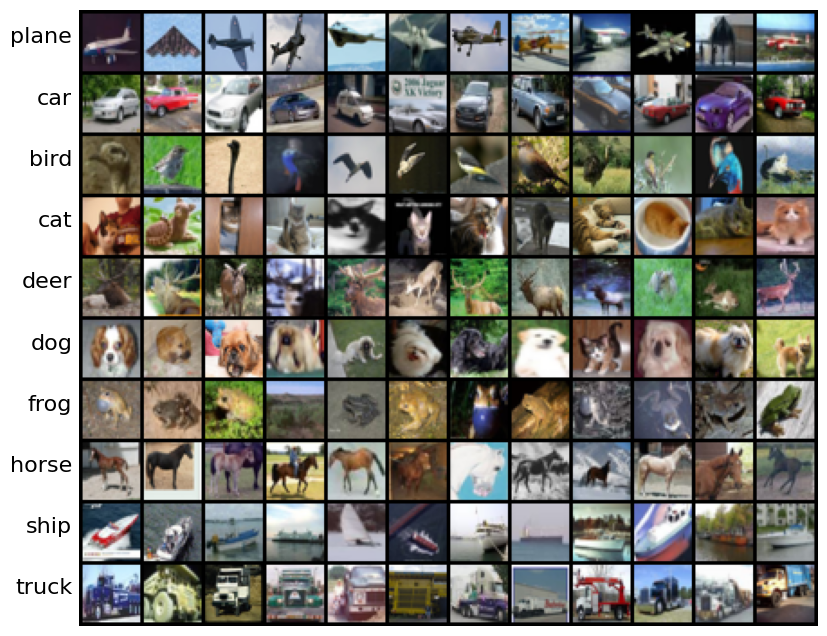

In [ ]:
import random
from torchvision.utils import make_grid

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = (y_train == y).nonzero()
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx].transpose(2,0,1))
img = torchvision.utils.make_grid(torch.Tensor(samples), nrow=samples_per_class)
plt.imshow(img.permute(1,2,0).to("cpu", torch.uint8).numpy())
plt.axis('off')
plt.show()

### Subsampling
- When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

In [ ]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = cifar10(num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: (500, 32, 32, 3)
  labels shape:  (500,)
Test set:
  data shape:  (250, 32, 32, 3)
  labels shape (250,)


### Preprocessing
- To use these real-world image data with neural networks, common practice is (1) dividing pixel values (0 to 255) into 0 to 1 by dividing with 255 and (2) substracting mean values (or optionally dividing with standard deviation).
- This process before running neural network is called pre-process

In [ ]:
def get_CIFAR10_data(num_train=49000, num_val=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare it for the linear classifier.

    Inputs:
    - num_train: [Optional] Number of training data
    - num_val: [Optional] Number of validation data
    - num_test: [Optional] Number of test data

    Returns:
    - x_train: `x_dtype` tensor of shape (num_train, 3, 32, 32)
    - y_train: int64 tensor of shape (num_train, 3, 32, 32)
    - x_val: `x_dtype` tensor of shape (num_val, 3, 32, 32)
    - y_val: int64 tensor of shape (num_val, 3, 32, 32)
    - x_test: `x_dtype` tensor of shape (num_test, 3, 32, 32)
    - y_test: int64 tensor of shape (num_test, 3, 32, 32)

    """
    # Load the raw CIFAR-10 data
    x_trainval, y_trainval, x_test, y_test = cifar10(num_train + num_val, num_test)

    # Subsample the data
    mask = list(range(num_train, num_train + num_val))
    x_val = x_trainval[mask]
    y_val = y_trainval[mask]
    mask = list(range(num_train))
    x_train = x_trainval[mask]
    y_train = y_trainval[mask]

    # Preprocessing: divide with 255 and reshape the image data into rows
    x_train = np.reshape(x_train / 255, (x_train.shape[0], -1))
    x_val = np.reshape(x_val / 255, (x_val.shape[0], -1))
    x_test = np.reshape(x_test / 255, (x_test.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(x_train, axis = 0)
    x_train -= mean_image
    x_val -= mean_image
    x_test -= mean_image

    # add bias dimension and transform into columns
    x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
    x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
    x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

    return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


#### Defining dictionary for our dataset

In [ ]:
data = {"X_train": x_train, "y_train": y_train, "X_val": x_val, "y_val": y_val, "X_test": x_test, "y_test": y_test}

# Part #1: Implementation of Simple Neural Network
- Now, let's start to implement neural network.
- You will first work on implementing simple 1-layer linear neural network with softmax loss

## Softmax Loss

- **Your task #1**: Compute the softmax loss and its gradient using no explicit loops. Store the loss in loss and the gradient in dW. If you are not careful here, it is easy to run into numeric instability.

In [ ]:
def softmax_loss(W, X, y, reg):
    """
    Softmax loss function

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) weight decay regularization strength

    Returns:
    - loss: loss as single float
    - dW: gradient with respect to weights W; an array of same shape as W
    """

    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    # Your task #1
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    scores = np.dot(X, W)
    scores -= np.max(scores, axis=1, keepdims=True)
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    loss = np.sum(-np.log(probs[np.arange(X.shape[0]), y])) / X.shape[0]
    loss += 0.5 * reg * np.sum(W * W)
    dscores = probs
    dscores[np.arange(X.shape[0]), y] -= 1
    dW = np.dot(X.T, dscores)
    dW /= X.shape[0]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

#### Test: Generate a random softmax weight matrix and use it to compute the loss.

In [ ]:
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss(W, x_val, y_val, reg=0.000005)

In [ ]:
print('loss: %f' % loss)

loss: 2.302517


## Linear Classifier
- **Your task #2**: Sample batch_size elements from the training data and their corresponding labels to use in this round of gradient descent. Store the data in ```X_batch``` and their corresponding labels in ```y_batch```; after sampling ```X_batch``` should have shape (batch_size, dim) and ```y_batch``` should have shape (batch_size,). *Hint*: Use np.random.choice to generate indices.
- **Your task #3**: Update the weights using the gradient and the learning rate.
- **Your task #4**: From the input and learned weights, make a prediction. Store the predicted labels in ```y_pred```.

In [ ]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Your task #2
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            idx = np.random.choice(num_train, batch_size)
            X_batch = X[idx]
            y_batch = y[idx]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # # Your task #3
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            self.W -= learning_rate * grad

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        # Your task #4
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

In [ ]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss(self.W, X_batch, y_batch, reg)

## Training neural network and optimizing hyperparameters with validation set
- **Your task #5**: Use the validation set to tune hyperparameters (regularization strength and learning rate). Also, save the best trained softmax classifer in ```best_softmax```. You should experiment with different ranges for the learning rates and regularization strengths. If you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

In [ ]:
results = {}
best_val = -1
best_softmax = None

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.linspace(1e-3, 1e-1, 5)
regularization_strengths = np.linspace(1e1, 1e5, 5)

# Your task #5
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
  for reg in regularization_strengths:
    softmax_classifier = Softmax()
    softmax_classifier.train(x_train, y_train, learning_rate=lr, reg=reg)
    train_pred = softmax_classifier.predict(data['X_train'])
    val_pred = softmax_classifier.predict(x_val)
    train_accuracy = np.mean(data['y_train'] == train_pred)
    val_accuracy = np.mean(data['y_val'] == val_pred)
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
      best_val = val_accuracy
      best_softmax = softmax_classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-03 reg 1.000000e+01 train accuracy: 0.249306 val accuracy: 0.265000
lr 1.000000e-03 reg 2.500750e+04 train accuracy: 0.264163 val accuracy: 0.267000
lr 1.000000e-03 reg 5.000500e+04 train accuracy: 0.246367 val accuracy: 0.261000
lr 1.000000e-03 reg 7.500250e+04 train accuracy: 0.249388 val accuracy: 0.265000
lr 1.000000e-03 reg 1.000000e+05 train accuracy: 0.252816 val accuracy: 0.267000
lr 2.575000e-02 reg 1.000000e+01 train accuracy: 0.349429 val accuracy: 0.359000
lr 2.575000e-02 reg 2.500750e+04 train accuracy: 0.348796 val accuracy: 0.363000
lr 2.575000e-02 reg 5.000500e+04 train accuracy: 0.344143 val accuracy: 0.354000
lr 2.575000e-02 reg 7.500250e+04 train accuracy: 0.351367 val accuracy: 0.360000
lr 2.575000e-02 reg 1.000000e+05 train accuracy: 0.341694 val accuracy: 0.360000
lr 5.050000e-02 reg 1.000000e+01 train accuracy: 0.368633 val accuracy: 0.369000
lr 5.050000e-02 reg 2.500750e+04 train accuracy: 0.367061 val accuracy: 0.368000
lr 5.050000e-02 reg 5.000500

Evaluate the best softmax on test set

In [ ]:
y_test_pred = best_softmax.predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.368000


# Part #2: Implmentation of deep neural networks
- Now, let's start to implement deep neural network, i.e., more than 2 layers with non-linear activation
- To this end, we need to implement forward pass (for inference) and backward pass (for gradient calculation)

In [ ]:
def rel_error(x, y):
  """ returns relative error
  Inputs:
  - x: inputs 1
  - y: inputs 2

  Return:
  - relative error
  """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Forward and Backward Passes for Neural Networks

### Linear layer: forward
- **Your task #6**: Implement the linear forward pass. Store the result in ```out```. You will need to reshape the input into rows.     

In [ ]:
def linear_forward(x, w, b):
    """
    Computes the forward pass for a linear (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # Your task #6
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N = x.shape[0]  # Number of examples
    D = np.prod(x.shape[1:])  # Flatten the dimensions of x
    x_reshaped = x.reshape(N, D)  # Reshape x to (N, D)

    out = x_reshaped.dot(w) + b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    cache = (x, w, b)
    return out, cache

#### Test the linear_forward function

In [ ]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = linear_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing linear_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing linear_forward function:
difference:  9.769849468192957e-10


### Linear layer: backward
- **Your task #7**: Implement the linear backward pass. Store the result in ```dx, dw, db```. You will need to reshape the input into rows.     

In [ ]:
def linear_backward(dout, cache):
    """
    Computes the backward pass for a linear layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    # Your task #7
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)

    dx = np.dot(dout, w.T).reshape(x.shape)
    db = np.sum(dout, axis=0)
    dw = np.dot(x_reshaped.T, dout)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return dx, dw, db

#### Test the linear_backward function

In [ ]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [ ]:
np.random.seed(3201)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: linear_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: linear_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: linear_forward(x, w, b)[0], b, dout)

_, cache = linear_forward(x, w, b)
dx, dw, db = linear_backward(dout, cache)

# The error should be around e-10 or less
print('Testing linear_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing linear_backward function:
dx error:  6.29418868514843e-11
dw error:  1.1146614042677453e-10
db error:  3.275653754855955e-12


### ReLU activation: forward
- **Your task #8**: Implement the ReLU forward pass. Store the result in ```out```.

In [ ]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    # Your task #8
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    out = np.maximum(0, x)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    cache = x
    return out, cache

#### Test the relu_forward function

In [ ]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


### ReLU activation: backward
- **Your task #9**: Implement the ReLU backward pass. Store the result in ```dx```.

In [ ]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    # Your task #9
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    dx = dout * (x > 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dx


#### Test the relu_backward function

In [ ]:
np.random.seed(3201)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756145698469566e-12


## Combining linear layer and ReLU activation
- There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity.
- For now take a look at the ```linear_relu_forward``` and `linear_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [ ]:
def linear_relu_forward(x, w, b):
    """
    Convenience layer that perorms an linear transform followed by a ReLU

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = linear_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

In [ ]:
def linear_relu_backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = linear_backward(da, fc_cache)
    return dx, dw, db

In [ ]:
np.random.seed(3201)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = linear_relu_forward(x, w, b)
dx, dw, db = linear_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: linear_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: linear_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: linear_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing linear_relu_forward and linear_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing linear_relu_forward and linear_relu_backward:
dx error:  5.416950382099926e-10
dw error:  1.453608737735031e-10
db error:  6.364335400123463e-12


### Softmax loss
- **Your task #10**: Compute the softmax loss and its gradient w.r.t only input and labels. Store the loss in `loss` and the gradient in `dW`.

In [ ]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    # Your task #10
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N = x.shape[0]
    exp_scores = np.exp(x)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    corect_logprobs = -np.log(probs[range(N), y])
    loss = np.sum(corect_logprobs) / N
    dx = probs.copy()
    dx[range(N), y] -= 1
    dx /= N

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dx

In [ ]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

In [ ]:
np.random.seed(3201)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('Testing softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing softmax_loss:
loss:  2.3028013064157706
dx error:  1.1312338832061434e-08


## Two-layer neural network
- **Your task #11**: Initialize the weights and biases of the two-layer net. Weights should be initialized from a Gaussian centered at 0.0 with standard deviation equal to weight_scale, and biases should be initialized to zero. All weights and biases should be stored in the dictionary `self.params`, with first layer weights and biases using the keys `W1` and `b1` and second layer weights and biases using the keys `W2` and `b2`.
- **Your task #12**: Implement the forward pass for the two-layer net, computing the class scores for X and storing them in the `scores` variable.
- **Your task #13**: Implement the backward pass for the two-layer net. Store the loss in the `loss` variable and gradients in the `grads` dictionary. Compute data loss using `softmax`, and make sure that `grads[k]` holds the gradients for `self.params[k]`. Don't forget to add L2 regularization. *NOTE*: To ensure that your implementation matches ours and you pass the  automated tests, make sure that your L2 regularization includes a factor of 0.5 to simplify the expression for the gradient.  

In [ ]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be linear - relu - linear - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32 + 1,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        # Your task #11
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b2'] = np.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        # Your task #12
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        z1 = X.dot(self.params['W1']) + self.params['b1']
        # Second layer: ReLU
        a1 = np.maximum(0, z1)
        # Second layer: Linear
        scores = a1.dot(self.params['W2']) + self.params['b2']
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}

        # Your task #13
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        num_train = X.shape[0]
        shifted_scores = scores - np.max(scores, axis=1, keepdims=True)  # For numerical stability
        softmax_scores = np.exp(shifted_scores) / np.sum(np.exp(shifted_scores), axis=1, keepdims=True)
        loss = -np.sum(np.log(softmax_scores[np.arange(num_train), y])) / num_train

        # Add regularization to the loss
        loss += 0.5 * self.reg * (np.sum(self.params['W1'] ** 2) + np.sum(self.params['W2'] ** 2))

        # Backward pass
        dscores = softmax_scores.copy()
        dscores[np.arange(num_train), y] -= 1
        dscores /= num_train

        # Gradient for W2 and b2
        grads['W2'] = a1.T.dot(dscores) + self.reg * self.params['W2']
        grads['b2'] = np.sum(dscores, axis=0)

        # Backprop into hidden layer
        da1 = dscores.dot(self.params['W2'].T)
        dz1 = da1 * (z1 > 0)  # Derivative of ReLU

        # Gradient for W1 and b1
        grads['W1'] = X.T.dot(dz1) + self.reg * self.params['W1']
        grads['b1'] = np.sum(dz1, axis=0)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [ ]:
np.random.seed(3201)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


## Solver
- Now, you will train the defined neural network using **Solver**. Solver-like function is a widely used nowadays (e.g., huggingface Trainser: https://huggingface.co/docs/transformers/main_classes/trainer).
- **Caution**: Your task is NOT implemting solver; just use the prodived solver below

In [ ]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = sgd(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

### Stochastic Gradient Descent (SGD)
- **Your task #14**: Implement the vanilla stochastic gradient descent update formula, which will be used with Solver above

In [ ]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    # Your task #14
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    learning_rate = config["learning_rate"]
    w -= learning_rate * dw
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return w, config

- **Your task #15**: Use a Solver instance to train a TwoLayerNet that achieves about 36% accuracy on the validation set.

In [ ]:
input_size = 32 * 32 * 3 + 1 # 1 for bias
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

# Your task #15
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = TwoLayerNet(input_dim=input_size, hidden_dim=hidden_size, num_classes=num_classes, reg=0.0)
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-2,
                },
                lr_decay=0.95,
                num_epochs=10,
                batch_size=100,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

(Iteration 1 / 4900) loss: 2.302588
(Epoch 0 / 10) train acc: 0.090000; val_acc: 0.119000
(Iteration 101 / 4900) loss: 2.302091
(Iteration 201 / 4900) loss: 2.301983
(Iteration 301 / 4900) loss: 2.302788
(Iteration 401 / 4900) loss: 2.302144
(Epoch 1 / 10) train acc: 0.186000; val_acc: 0.155000
(Iteration 501 / 4900) loss: 2.299882
(Iteration 601 / 4900) loss: 2.298719
(Iteration 701 / 4900) loss: 2.282451
(Iteration 801 / 4900) loss: 2.269777
(Iteration 901 / 4900) loss: 2.264663
(Epoch 2 / 10) train acc: 0.179000; val_acc: 0.184000
(Iteration 1001 / 4900) loss: 2.191920
(Iteration 1101 / 4900) loss: 2.185679
(Iteration 1201 / 4900) loss: 2.176625
(Iteration 1301 / 4900) loss: 2.082985
(Iteration 1401 / 4900) loss: 2.004400
(Epoch 3 / 10) train acc: 0.232000; val_acc: 0.245000
(Iteration 1501 / 4900) loss: 2.128175
(Iteration 1601 / 4900) loss: 2.056709
(Iteration 1701 / 4900) loss: 2.067196
(Iteration 1801 / 4900) loss: 1.983235
(Iteration 1901 / 4900) loss: 1.981180
(Epoch 4 / 10) t

### Plot to visualize training loss and train / val accuracy

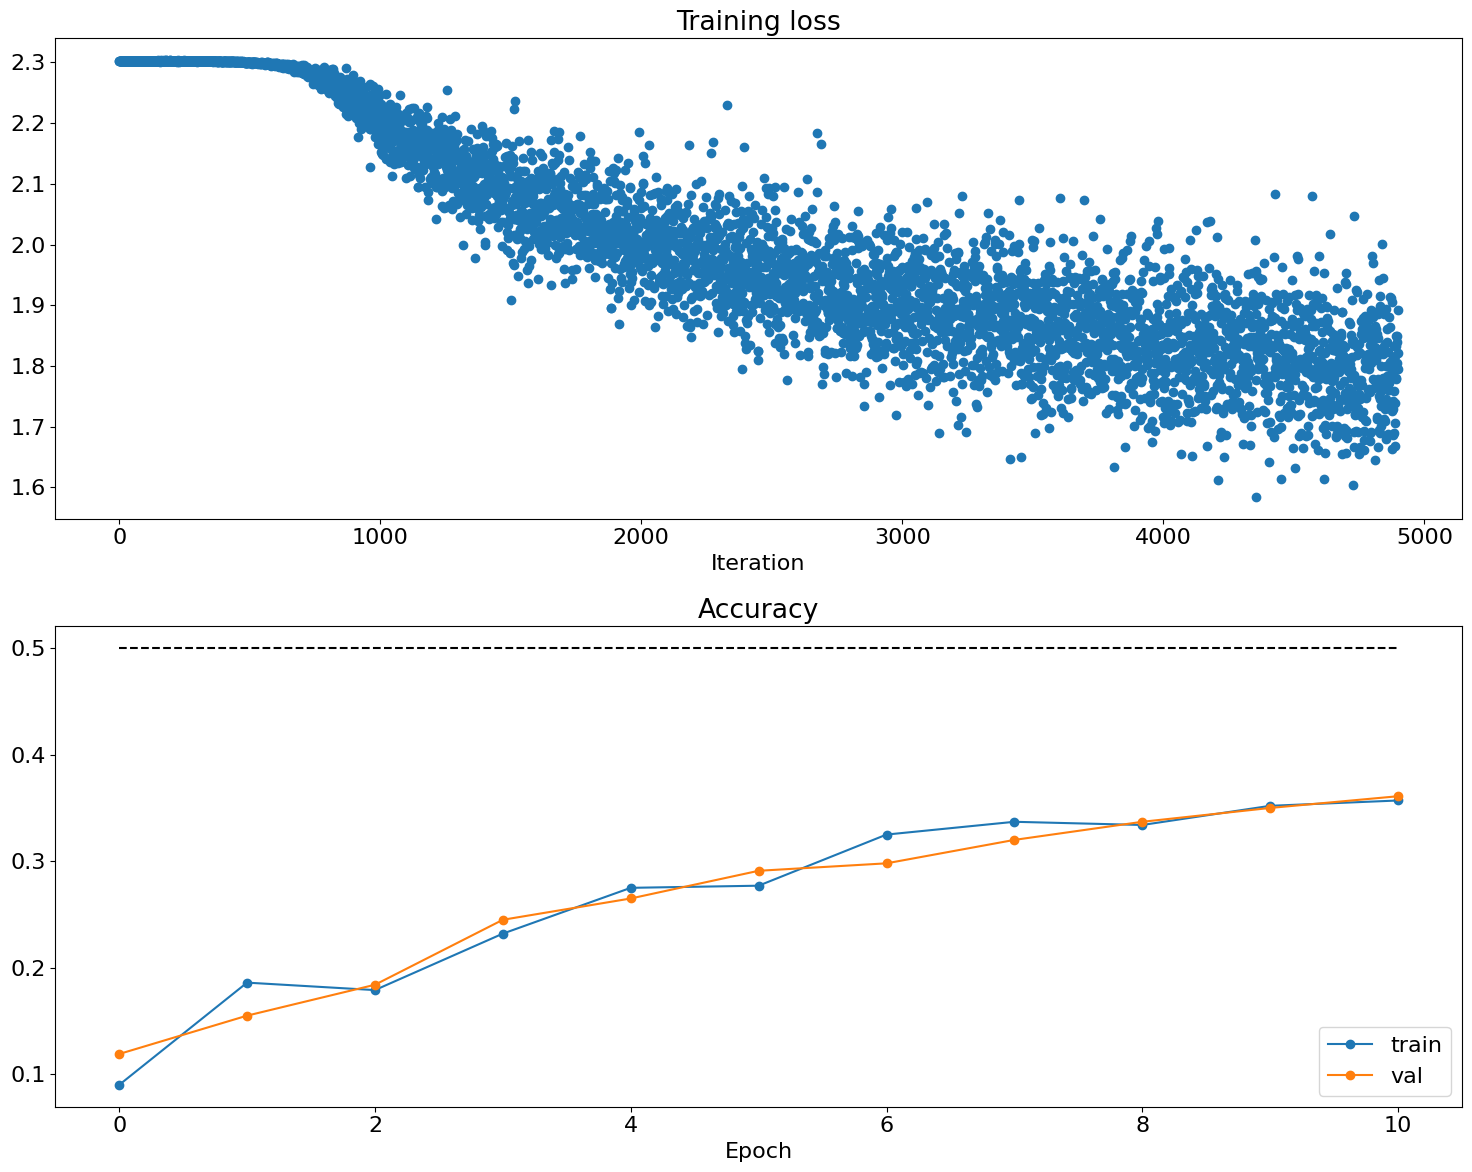

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.tight_layout()
plt.show()

# Part #3: Hyper-parameter tuning
- **Your task #16**. Tune hyperparameters using the validation set. Store your best trained model in `best_model`. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

- **Minimum Goal**. You should be aim to achieve a classification accuracy of greater than 45% on the validation set. Your goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques.

In [ ]:
best_model = None

# Your task #16
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_val_accuracy = 0

hidden_sizes = [50]
learning_rates = [1e-1]
regularization_strengths = [0.001]
num_epochs = 15

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for reg in regularization_strengths:
            model = TwoLayerNet(input_dim=32 * 32 * 3 + 1, hidden_dim=hidden_size, num_classes=10, reg=reg)
            solver = Solver(model, data,
                            update_rule='sgd',
                            optim_config={
                                'learning_rate': learning_rate,
                            },
                            lr_decay=0.95,
                            num_epochs=num_epochs,
                            batch_size=100,
                            verbose=True
                            )
            solver.train()

            val_acc = solver.check_accuracy(data['X_val'], data['y_val'])

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_model = model

print('Best validation accuracy achieved: %f' % best_val_accuracy)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

(Iteration 1 / 7350) loss: 2.302667
(Epoch 0 / 15) train acc: 0.106000; val_acc: 0.098000
(Iteration 11 / 7350) loss: 2.303448
(Iteration 21 / 7350) loss: 2.303240
(Iteration 31 / 7350) loss: 2.301886
(Iteration 41 / 7350) loss: 2.305177
(Iteration 51 / 7350) loss: 2.300680
(Iteration 61 / 7350) loss: 2.299577
(Iteration 71 / 7350) loss: 2.279078
(Iteration 81 / 7350) loss: 2.257168
(Iteration 91 / 7350) loss: 2.236146
(Iteration 101 / 7350) loss: 2.199405
(Iteration 111 / 7350) loss: 2.169429
(Iteration 121 / 7350) loss: 2.151244
(Iteration 131 / 7350) loss: 2.127260
(Iteration 141 / 7350) loss: 2.144854
(Iteration 151 / 7350) loss: 2.062492
(Iteration 161 / 7350) loss: 2.163763
(Iteration 171 / 7350) loss: 2.082474
(Iteration 181 / 7350) loss: 2.115287
(Iteration 191 / 7350) loss: 1.962931
(Iteration 201 / 7350) loss: 2.071349
(Iteration 211 / 7350) loss: 2.015730
(Iteration 221 / 7350) loss: 2.058514
(Iteration 231 / 7350) loss: 1.844557
(Iteration 241 / 7350) loss: 1.915963
(Iterat

### Test

In [ ]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.533


In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.509
